In [210]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import OneHotEncoder
from matplotlib.patches import Circle, Rectangle, Arc

df = pd.read_csv("all_shot_data.csv")
#convert game clock
df['GAME_CLOCK'] = (df['PERIOD'] - 1) * 12 + (12 - df['MINUTES_REMAINING'] - df['SECONDS_REMAINING'] / 60)
#drop unneccessary columns
columns_to_drop = ['GRID_TYPE','GAME_ID','TEAM_ID','PLAYER_ID','GAME_EVENT_ID','SHOT_ATTEMPTED_FLAG',
'GAME_DATE','HTM','VTM','HOME_TEAM_NAME',"AWAY_TEAM_NAME", 'TEAM_NAME', "MINUTES_REMAINING",
"SECONDS_REMAINING","PERIOD","EVENT_TYPE","SHOT_ZONE_AREA",'SHOT_ZONE_RANGE','Season Type','SHOT_ZONE_BASIC',"player_name","LOCATION", "LOC_X","LOC_Y"]
df = df.drop(columns = columns_to_drop)

In [211]:
#categorize all actions into four type of shots
def action_type_processor(action):
    lower_case = action.lower()
    if 'dunk' in lower_case:
        return 'dunk'
    elif 'layup' in lower_case:
        return 'layup'
    elif 'hook' in lower_case:
        return 'hookshot'
    elif 'jump'in lower_case or 'fadeaway' in lower_case:
        return 'jumpshot'
    else:
        return np.nan
def shot_type_processor(shot):
    if shot == '3PT Field Goal':
        return 3
    else:
        return 2
df['ACTION_TYPE'] = df['ACTION_TYPE'].apply(action_type_processor)
df['SHOT_TYPE'] = df['SHOT_TYPE'].apply(shot_type_processor)
df = df.dropna()

In [212]:
#second data set rating
with open('league.json') as f:
    data = json.load(f)

df_rating = pd.DataFrame(data)
columns_to_keep = ['name','overallAttribute', 'closeShot','midRangeShot','threePointShot','postHook','drivingDunk']
df_rating = df_rating[columns_to_keep]

In [213]:
def fill_attributes(row,df_rating):
    player_name = row['PLAYER_NAME']
    action_type = row['ACTION_TYPE']
    point = row['SHOT_TYPE']
    if player_name not in df_rating['name'].values:
        return np.nan, np.nan
    if action_type == 'layup':
        rating = df_rating.loc[df_rating['name'] == player_name, 'closeShot'].values[0]
    elif action_type == 'dunk':
        rating = df_rating.loc[df_rating['name'] == player_name, 'drivingDunk'].values[0]
    elif action_type == 'hookshot':
        rating = df_rating.loc[df_rating['name'] == player_name, 'postHook'].values[0]
    elif action_type == 'jumpshot':
        if point == 2:
            rating = df_rating.loc[df_rating['name'] == player_name, 'midRangeShot'].values[0]
        elif point == 3:
            rating = df_rating.loc[df_rating['name'] == player_name, 'threePointShot'].values[0]
    overall = df_rating.loc[df_rating['name'] == player_name, 'overallAttribute'].values[0]
    return rating, overall

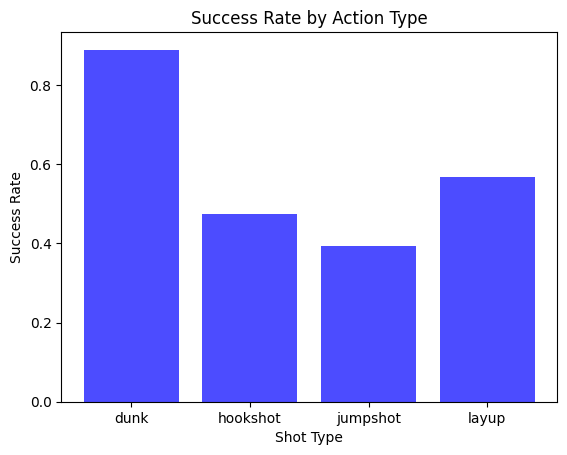

In [214]:
## success rate by action type
success_rate_by_type = df.groupby('ACTION_TYPE')['SHOT_MADE_FLAG'].mean().reset_index()

plt.bar(success_rate_by_type['ACTION_TYPE'], success_rate_by_type['SHOT_MADE_FLAG'], color='blue', alpha=0.7)
plt.xlabel('Shot Type')
plt.ylabel('Success Rate')
plt.title('Success Rate by Action Type')
plt.xticks(ticks=success_rate_by_type['ACTION_TYPE'], labels=success_rate_by_type['ACTION_TYPE'].astype(str))
plt.show()

In [215]:
df[['rating', 'overall']] = df.apply(fill_attributes, axis=1, df_rating=df_rating, result_type="expand")
df = df.dropna()

In [216]:
df = pd.get_dummies(df, columns=['ACTION_TYPE'], prefix='', prefix_sep='')
df[['dunk', 'layup', 'jumpshot','hookshot']] = df[['dunk', 'layup', 'jumpshot','hookshot']].astype(int)

/var/folders/dz/p6z2rp253yv1xd1y827n1w440000gn/T/ipykernel_61247/1958827265.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  success_rate = df.groupby('distance_bin')['SHOT_MADE_FLAG'].mean().reset_index()


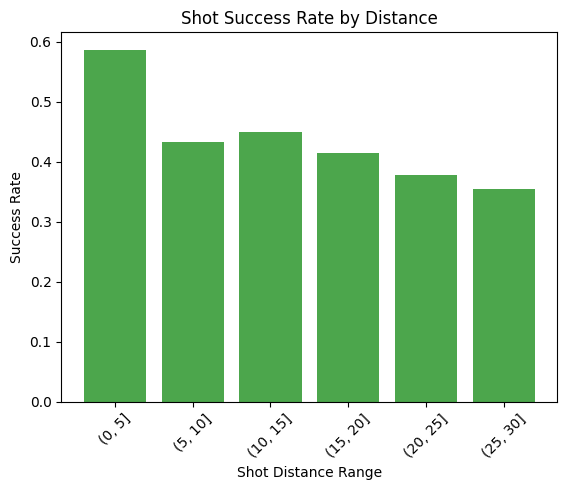

In [217]:
## shot sucess rate by distance
df['distance_bin'] = pd.cut(df['SHOT_DISTANCE'], bins=range(0, 35, 5))
success_rate = df.groupby('distance_bin')['SHOT_MADE_FLAG'].mean().reset_index()

plt.bar(success_rate['distance_bin'].astype(str), success_rate['SHOT_MADE_FLAG'], color='green', alpha=0.7)
plt.xlabel('Shot Distance Range')
plt.ylabel('Success Rate')
plt.title('Shot Success Rate by Distance')
plt.xticks(rotation=45)
plt.show()

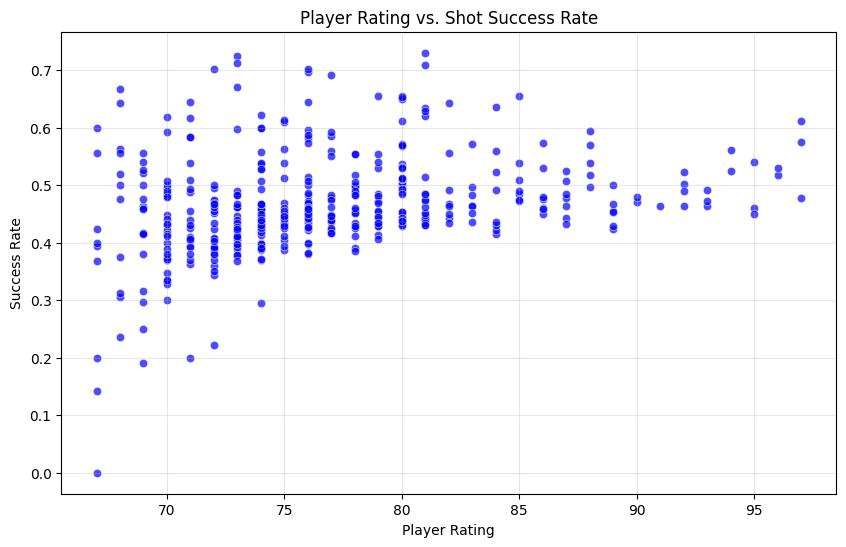

In [218]:
## player rating vs shto succes rate
import seaborn as sns

# Calculate success rate for each player
player_stats = df.groupby(['PLAYER_NAME', 'overall'])['SHOT_MADE_FLAG'].mean().reset_index()
player_stats.rename(columns={'SHOT_MADE_FLAG': 'Success Rate'}, inplace=True)

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='overall', y='Success Rate', data=player_stats, alpha=0.7, color='blue')

# Add plot labels and title
plt.xlabel('Player Rating')
plt.ylabel('Success Rate')
plt.title('Player Rating vs. Shot Success Rate')
plt.grid(alpha=0.3)
plt.show()

In [219]:
df = df.drop(columns = ['PLAYER_NAME'])

In [223]:
df = df.drop(columns = ['distance_bin'])

### Logistic Regression

In [224]:
# Define features and target
X = df.drop(columns=['SHOT_MADE_FLAG'])
y = df['SHOT_MADE_FLAG']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = LogisticRegression(random_state=42, max_iter=1000)  # Increased max_iter for convergence
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)

Accuracy: 0.62
Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.72      0.66     22140
           1       0.62      0.50      0.55     20297

    accuracy                           0.62     42437
   macro avg       0.62      0.61      0.61     42437
weighted avg       0.62      0.62      0.61     42437



In [225]:
# Get feature names
feature_names = X.columns

# Get coefficients and intercept
coefficients = clf.coef_[0]
intercept = clf.intercept_[0]

# Print the formula
print("Logistic Regression Formula:")
print(f"P(scored) = 1 / (1 + e^-({intercept:.4f}", end='')

# Split the formula into two lines
print(" +")  # Add a line break here
for feat, coef in zip(feature_names, coefficients):
    print(f" {coef:.4f}*{feat}", end='')
print("))")

# Print feature importance
print("\nFeature Coefficients:")
for feat, coef in zip(feature_names, coefficients):
    print(f"{feat}: {coef:.4f}")

Logistic Regression Formula:
P(scored) = 1 / (1 + e^-(-1.4107 +
 0.5275*SHOT_TYPE -0.0592*SHOT_DISTANCE -0.0017*GAME_CLOCK 0.0178*rating 0.0017*overall 1.0467*dunk -0.7904*hookshot -0.7732*jumpshot -0.8908*layup))

Feature Coefficients:
SHOT_TYPE: 0.5275
SHOT_DISTANCE: -0.0592
GAME_CLOCK: -0.0017
rating: 0.0178
overall: 0.0017
dunk: 1.0467
hookshot: -0.7904
jumpshot: -0.7732
layup: -0.8908


In [226]:
# Print feature importances (coefficients for logistic regression)
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': abs(clf.coef_[0])  # Take absolute values of coefficients
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(importance_df)


Feature Importances:
         Feature  Importance
5           dunk    1.046747
8          layup    0.890792
6       hookshot    0.790384
7       jumpshot    0.773161
0      SHOT_TYPE    0.527509
1  SHOT_DISTANCE    0.059196
3         rating    0.017795
2     GAME_CLOCK    0.001725
4        overall    0.001702


In [227]:
# Predict probabilities
y_prob = clf.predict_proba(X_test)

# Display probability for each class
print("Probability for each class (missed=0, scored=1):")
print(y_prob)

Probability for each class (missed=0, scored=1):
[[0.62041186 0.37958814]
 [0.64302507 0.35697493]
 [0.49015929 0.50984071]
 ...
 [0.43994322 0.56005678]
 [0.096714   0.903286  ]
 [0.62616963 0.37383037]]


In [228]:
player_stats = np.array([[3, 24, 47, 99, 95, 0, 0, 1, 0],
                         [3, 24, 47, 80, 83, 0, 0, 1, 0],
                         [3, 24, 47, 80, 78, 0, 0, 1, 0],
                         [3, 24, 47, 88, 79, 0, 0, 1, 0],
                         [3, 24, 47, 82, 79, 0, 0, 1, 0 ]])  
# Define player names corresponding to the player_stats
player_names = ["Stephen Curry", "Draymond Green", "Andrew Wiggins", "Buddy Hield", "Brandin Podziemski"]

# Predict probabilities
player_y_prob = clf.predict_proba(player_stats)

# Print probabilities with player names and expected value
print("(missed=0, scored=1)")
for name, prob in zip(player_names, player_y_prob):
    expected_value = prob[1] * 3  # Calculate expected value
    print(f"{name}: {prob}, Expected Value: {expected_value:.2f}")


(missed=0, scored=1)
Stephen Curry: [0.54482364 0.45517636], Expected Value: 1.37
Draymond Green: [0.63141603 0.36858397], Expected Value: 1.11
Andrew Wiggins: [0.63339423 0.36660577], Expected Value: 1.10
Buddy Hield: [0.59934764 0.40065236], Expected Value: 1.20
Brandin Podziemski: [0.62469276 0.37530724], Expected Value: 1.13


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [229]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Coefficients from the logistic regression formula
# coef_intercept = -1.2650
# coef_shot_distance = -0.0465
# coef_jumpshot = -0.5809
# coef_hookshot = -0.5937
# coef_layup = -0.4474
# coef_dunk = 1.5788

# # Define the logistic function for scoring probability
# def logistic(shot_distance, action_type, coef_intercept, coef_shot_distance, coef_jumpshot, coef_hookshot, coef_layup, coef_dunk):
#     if action_type == 'jumpshot':
#         action_coef = coef_jumpshot
#     elif action_type == 'hookshot':
#         action_coef = coef_hookshot
#     elif action_type == 'layup':
#         action_coef = coef_layup
#     elif action_type == 'dunk':
#         action_coef = coef_dunk
#     else:
#         raise ValueError("Unknown action type")

#     return 1 / (1 + np.exp(-(coef_intercept + coef_shot_distance * shot_distance + action_coef)))

# # Range of SHOT_DISTANCE values
# shot_distance_values = np.linspace(1, 30, 100)

# # Compute probabilities for different action types
# probabilities_jumpshot = logistic(shot_distance_values, 'jumpshot', coef_intercept, coef_shot_distance, coef_jumpshot, coef_hookshot, coef_layup, coef_dunk)
# probabilities_hookshot = logistic(shot_distance_values, 'hookshot', coef_intercept, coef_shot_distance, coef_jumpshot, coef_hookshot, coef_layup, coef_dunk)
# probabilities_layup = logistic(shot_distance_values, 'layup', coef_intercept, coef_shot_distance, coef_jumpshot, coef_hookshot, coef_layup, coef_dunk)
# probabilities_dunk = logistic(shot_distance_values, 'dunk', coef_intercept, coef_shot_distance, coef_jumpshot, coef_hookshot, coef_layup, coef_dunk)

# # Plotting the logistic regression curves for different shot types
# plt.figure(figsize=(10, 6))
# plt.plot(shot_distance_values, probabilities_jumpshot, label='P(scored) with jumpshot', color='blue')
# plt.plot(shot_distance_values, probabilities_hookshot, label='P(scored) with hookshot', color='green')
# plt.plot(shot_distance_values, probabilities_layup, label='P(scored) with layup', color='orange')
# plt.plot(shot_distance_values, probabilities_dunk, label='P(scored) with dunk', color='red')

# plt.xlabel('SHOT_DISTANCE')
# plt.ylabel('P(scored)')
# plt.title('Logistic Regression Curve: Probability of Scoring vs SHOT_DISTANCE for Different Actions')
# plt.legend()
# plt.grid(True)
# plt.show()



### DecisionTreeClassification

In [198]:
# Define features and target
X = df.drop(columns=['SHOT_MADE_FLAG'])
y = df['SHOT_MADE_FLAG']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=42, max_depth = 4)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(report)


Accuracy: 0.63
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.84      0.70     22140
           1       0.69      0.39      0.50     20297

    accuracy                           0.63     42437
   macro avg       0.65      0.62      0.60     42437
weighted avg       0.64      0.63      0.61     42437



In [199]:
feature_importances = clf.feature_importances_

# Create a DataFrame to show the features and their importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Feature Importances:")
print(importance_df)

Feature Importances:
         Feature  Importance
1  SHOT_DISTANCE    0.787096
5           dunk    0.159283
3         rating    0.038365
8          layup    0.006963
4        overall    0.004952
7       jumpshot    0.002840
2     GAME_CLOCK    0.000502
0      SHOT_TYPE    0.000000
6       hookshot    0.000000


In [200]:
plt.figure(figsize=(40, 20)) 
plot_tree(clf, 
          filled=True, 
          feature_names=X.columns, 
          class_names=["Miss", "Make"], 
          rounded=True, 
          fontsize=14)  
plt.savefig("decision_tree.png", dpi=300)  
plt.close()

In [82]:
def draw_court(ax=None, color='black', lw=2, outer_lines=False):
    # If an axes object isn't provided to plot onto, just get current one
    if ax is None:
        ax = plt.gca()
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)
    backboard = Rectangle((-30, -7.5), 60, -1, linewidth=lw, color=color)
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                      bottom_free_throw, restricted, corner_three_a,
                      corner_three_b, three_arc, center_outer_arc,
                      center_inner_arc]
    if outer_lines:
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)
    for element in court_elements:
        ax.add_patch(element)
    return ax

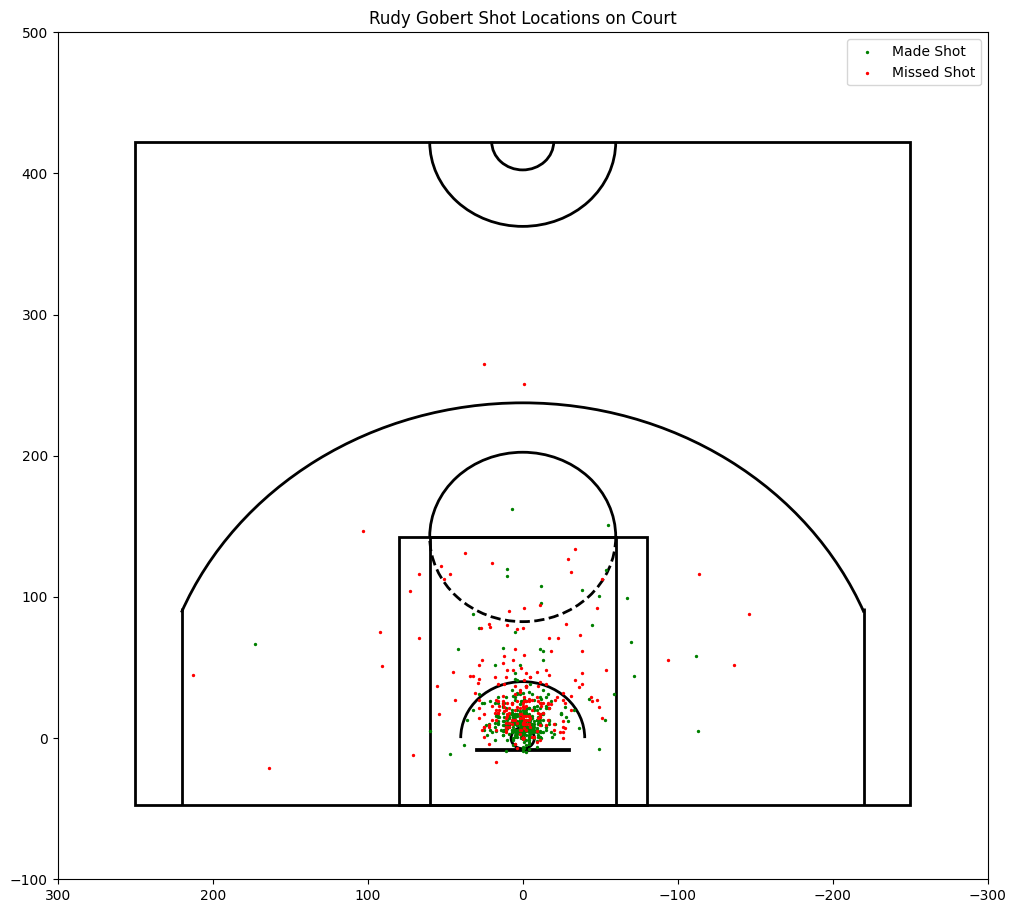

In [ ]:
def player_shotChart(name):
    player_df = df[df['PLAYER_NAME'] == name]
    plt.figure(figsize=(12, 11))
    draw_court(outer_lines=True) 

    plt.scatter(player_df.LOC_X[player_df.SHOT_MADE_FLAG == 1], 
                player_df.LOC_Y[player_df.SHOT_MADE_FLAG == 1], 
                color='green', label='Made Shot', s=2)

    plt.scatter(player_df.LOC_X[player_df.SHOT_MADE_FLAG == 0], 
                player_df.LOC_Y[player_df.SHOT_MADE_FLAG == 0], 
                color='red', label='Missed Shot', s=2)

    plt.xlim(300, -300)  # Set x-axis limits
    plt.ylim(-100, 500)  # Set y-axis limits
    plt.title(f'{name} Shot Locations on Court')
    plt.legend()
    plt.show()
player_shotChart('Rudy Gobert')